# Récupération des Etablissements d'enseignement supérieurs




## Docker

En préalable lancer un container docker avec un volume `data` exposé

```
$ docker run -d --publish=7474:7474 \
    --publish=7687:7687  \
    --volume=$HOME/neo4j/labos/data:/data  \
    --env=NEO4J_AUTH=none  \
    --name labos_neo4j \
    neo4j
```

Vérifier que le serveur fonctionne bien : 
    
```
$ docker container ps
CONTAINER ID        IMAGE               COMMAND                  CREATED             STATUS                          PORTS                                                      NAMES
c040be993542        neo4j               "/sbin/tini -g -- /d…"   5 seconds ago       Up 4 seconds                    0.0.0.0:7474->7474/tcp, 7473/tcp, 0.0.0.0:7687->7687/tcp   labos_neo4j
```

In [1]:
import pandas as pd
import io
import requests

from py2neo import Graph, Node, Relationship
from py2neo.database import Schema

graph = Graph()

## Récupération des données

In [2]:
structure_url = 'https://data.enseignementsup-recherche.gouv.fr/explore/dataset/fr-esr-structures-recherche-publiques-actives/download/?format=json'
structures = pd.read_json(io.StringIO(requests.get(structure_url).content.decode('utf-8')))

In [56]:
_id = lambda p : p
_to_int = lambda p : int(p) if p != '' else None
s_ = lambda s,name : s.get(name,'').split(';')
same_or_none = lambda x : x if x else None

def create_struct(structures, structure):
    scalars_properties = {'numero_national_de_structure': _id, 
                          'libelle': _id,
                          'sigle': _id,
                          'annee_de_creation': _to_int
                         }
    as_map = {}
    for key, fn in scalars_properties.items():
        value = structure.get(key)
        as_map[key] = fn(value)
    structures.append(as_map)

def create_tutelles(tutelles, structure, relations):
    
    tutelle_list = zip(s_(structure,'tutelles'), 
                       s_(structure,'code_de_type_de_tutelle'), 
                       s_(structure,'sigles_des_tutelles'),
                       s_(structure,'uai_des_tutelles'))
    
    
    for position, tutelle in enumerate(tutelle_list):
            label, code_type, sigle, uai = tutelle
            as_map = {}
            if label: 
                tutelles.append(as_map)
                as_map['label'] = same_or_none(label)
                as_map['type'] = same_or_none(code_type)
                as_map['sigle'] = same_or_none(sigle)
                as_map['uai'] = same_or_none(uai)  
                
                num_national = structure.get('numero_national_de_structure')
                relations.append( { 'nns': num_national, 'uai': uai, 'position': position})


In [62]:
def create_domain(domains, structure, relations) :
    domain_list = zip(s_(structure,'code_domaine_scientifique'), 
                       s_(structure,'domaine_scientifique'))
    for position, domain in enumerate(domain_list):
        code, label = domain
        if code:
            as_map = {}
            as_map['code'] = code
            as_map['label'] = label
            domains.append(as_map)

            num_national = structure.get('numero_national_de_structure')
            relations.append( { 'nns': num_national, 'code': code, 'position': position})


In [63]:
structures_list = []
tutelles_list = []
relations_structure_tutelles = []
domain_list = []
relations_structure_domains = []

for structure in structures['fields']:
    create_struct(structures_list, structure)
    create_tutelles(tutelles_list, structure, relations_structure_tutelles)
    create_domain(domain_list,structure, relations_structure_domains)

structure_df = pd.DataFrame(structures_list)
tutelles_df = pd.DataFrame(tutelles_list)
relations_df = pd.DataFrame(relations_structure_tutelles)  
domains_pd = pd.DataFrame(domain_list)
domains_relation_pd = pd.DataFrame(relations_structure_domains)

structure_df.drop_duplicates().to_csv('/tmp/structures.csv', sep=";")
tutelles_df.drop_duplicates().to_csv('/tmp/tutelles.csv', sep=";")
relations_df.drop_duplicates().to_csv('/tmp/relation_structure_tutelles.csv', sep=';')
domains_pd.drop_duplicates().to_csv('/tmp/domains.csv', sep=';')
domains_relation_pd.drop_duplicates().to_csv('/tmp/domain_relations.csv', sep=";")


Si vous exécuter sur votre poste, allez copier les fichiers sur le docker dont nous avons forcé le nom à _labos_neo4j_.

Dans mon cas, mon container _neo4j_ s'appelle _musing_vaughan_.

```bash
cd /tmp
docker container cp structures.csv labos_neo4j:/var/lib/neo4j/import
docker container cp tutelles.csv labos_neo4j:/var/lib/neo4j/import
docker container cp relation_structure_tutelles.csv labos_neo4j:/var/lib/neo4j/import
docker container cp domains.csv labos_neo4j:/var/lib/neo4j/import
docker container cp domain_relations.csv labos_neo4j:/var/lib/neo4j/import

```

### Préparation de l'import

```cypher
CREATE INDEX ON :Structure(nns)
```

```cypher
CREATE INDEX ON :Tutelle(uai)
```

### Chargement des tutelles

```cypher
LOAD CSV WITH HEADERS FROM 'file:///tutelles.csv' as row FIELDTERMINATOR ';'
CREATE (:Tutelle { uai: row.uai, type: row.type, label: row.label, sigle: row.sigle})
```

 Added 276 labels, created 276 nodes, set 853 properties, completed after 564 ms.

### Chargement des structures

```cypher
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM "file:///structures.csv" as row FIELDTERMINATOR ';'
CREATE (:Structure {nns: row.numero_national_de_structure, sigle: row.sigle, label: row.libelle, creation_year: toInteger(row.annee_de_creation)})
```
 Added 3757 labels, created 3757 nodes, set 10364 properties, completed after 2253 ms.

### Etablissement des relations

```cypher
LOAD CSV WITH HEADERS FROM "file:///relation_structure_tutelles.csv" as row FIELDTERMINATOR ';'
MATCH (s:Structure {nns: row.nns}), (t:Tutelle {uai: row.uai})
CREATE (s)-[:ATTACHED_TO {position: toInteger(row.position)}]->(t)
```
 Set 7974 properties, created 7974 relationships, completed after 1484 ms.

### Mise à jour en masse

```cypher
LOAD CSV WITH HEADERS FROM "file:///structures.csv" as row FIELDTERMINATOR ';'
MATCH (s:Structure {nns: row.numero_national_de_structure})
SET s.label = row.libelle
```
 Set 3801 properties, completed after 645 ms.

### Les domaines

```cypher
LOAD CSV WITH HEADERS FROM "file:///domains.csv" as row FIELDTERMINATOR ';' 
MERGE (d:Domain { code: row.code, label: row.label})
```

```cypher
LOAD CSV WITH HEADERS FROM "file:///domain_relations.csv" as row FIELDTERMINATOR ';' 
MATCH (s:Structure {nns: row.nns}), (t:Domain {code: row.code})
CREATE (s)-[:WORK_IN {position: toInteger(row.position)}]->(t)
```

## Quelques recherches

### Nombre de structures par tutelles

```cypher
MATCH (t:Tutelle)-[r:ATTACHED_TO]-(s:Structure)
WITH t, count(s) as nb
RETURN t.label as NomTutelle, nb as NombreStructure ORDER BY nb DESC
```

In [68]:
graph.run('''
MATCH (t:Tutelle)-[r:ATTACHED_TO]-(s:Structure)
WITH t, count(s) as nb
RETURN t.label as NomTutelle, nb as NombreStructure ORDER BY nb DESC
''').to_data_frame().head(10)

,NomTutelle,NombreStructure
0,Centre national de la recherche scientifique,1572
1,Institut national de la santé et de la recherc...,502
2,Institut national de la recherche agronomique,322
3,Institut national de recherche en informatique...,293
4,Institut Pasteur,197
5,Sorbonne Université,179
6,Commissariat à l'énergie atomique et aux énerg...,164
7,Aix-Marseille université,140
8,Université de Grenoble Alpes,140
9,Université Paris-Sud,109


### Structures rattachées à Paris-Sud et CNRS

```cypher
MATCH (t:Tutelle {uai: "0911101C"})<-[r:ATTACHED_TO]-(s:Structure) return s, t
```
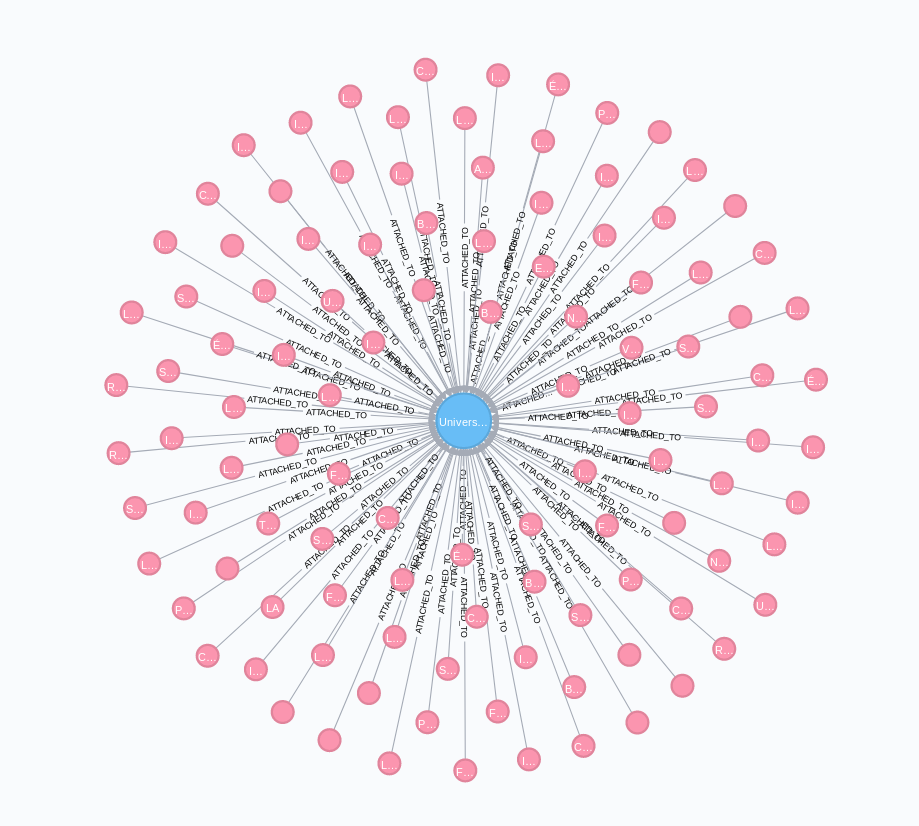

### Structures communes Paris-Sud, CNRS

```cypher
MATCH (t:Tutelle {uai: "0911101C"})<-[:ATTACHED_TO]-(s:Structure)-[:ATTACHED_TO]->(c:Tutelle {uai: "0753639Y"}) return s, t, c```

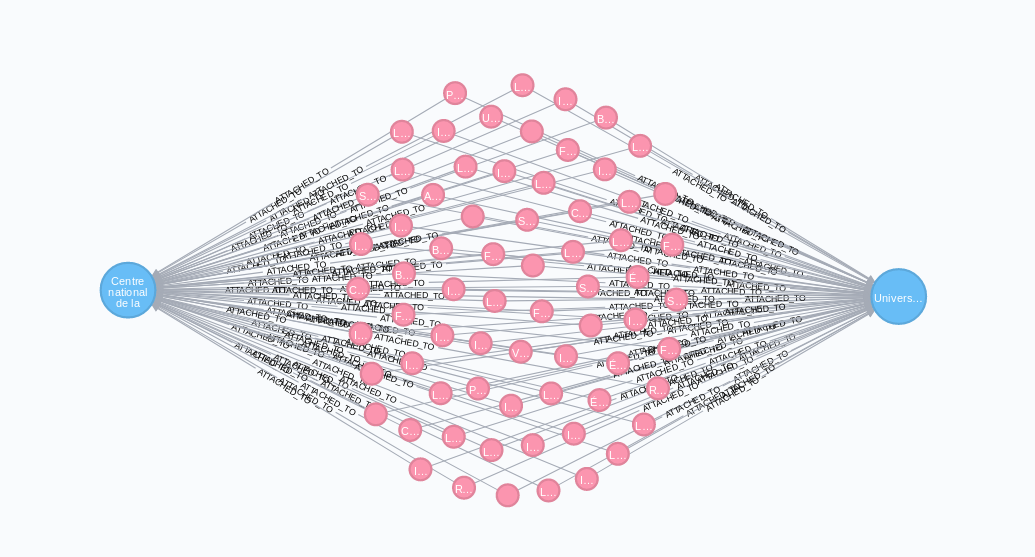


### Domaine des structures communes 

```cypher
MATCH (t:Tutelle {uai: "0911101C"})<-[:ATTACHED_TO]-(s:Structure)-[:ATTACHED_TO]->(c:Tutelle {uai: "0753639Y"}) WITH s MATCH (s)-[:WORK_IN]->(d) RETURN s.label, d.label
```

Avec utilisation de py2neo 

In [72]:
graph.run('''
MATCH (t:Tutelle {uai: "0911101C"})<-[:ATTACHED_TO]-(s:Structure)-[:ATTACHED_TO]->(c:Tutelle {uai: "0753639Y"})
WITH s 
MATCH (s)-[:WORK_IN]->(d) 
RETURN s.label as Labo, d.label as Domain
''').to_data_frame()

,Domain,Labo
0,Physique,"FLUIDES, AUTOMATIQUE ET SYSTÈMES THERMIQUES"
1,Sciences pour l'ingenieur,"FLUIDES, AUTOMATIQUE ET SYSTÈMES THERMIQUES"
2,"Biologie, medecine et sante",LABORATOIRE DE MALADIES NEURODEGENERATIVES : M...
3,"Biologie, medecine et sante",INSTITUT DE BIOLOGIE INTÉGRATIVE DE LA CELLULE
4,Sciences et technologies de l'information et d...,MAISON DE LA SIMULATION
5,Mathematiques et leurs interactions,ITER (FCM/ITER)
6,Chimie,ITER (FCM/ITER)
7,Sciences pour l'ingenieur,ITER (FCM/ITER)
8,Physique,ITER (FCM/ITER)
9,"Biologie, medecine et sante","ÉVOLUTION, GÉNOMES, COMPORTEMENT ET ÉCOLOGIE"
